### Preprocessing h-indices with transformers.py using data from year 2000 onwards

##### Outcome: data_export.csv -> shortened version of 2017-2024 paper data with prediction labels

In [1]:
import pandas as pd
from tqdm import tqdm
import os
from transformers import DataTransformer
import matplotlib.pyplot as plt
import re
import ast

transformer = DataTransformer()

In [2]:
file1 = "all_papers_labeled_2017_2018.csv"
file2 = "all_papers_labeled_2019_2021.csv"
file3 = "all_papers_labeled_2022_2024.csv"

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

data = pd.concat([df1, df2, df3], ignore_index=True)

len_before_processing = len(data)

filtered_data = data[data['language'] == 'en']

#  "soccer" or "football" in the abstract
filtered_data['mention_count'] = filtered_data['abstract'].str.count(r'\bsoccer\b|\bfootball\b', flags=re.IGNORECASE)

#  "soccer" or "football" is mentioned in the title
filtered_data['title_match'] = filtered_data['title'].str.contains(r'\bsoccer\b|\bfootball\b', flags=re.IGNORECASE)

def filter_concepts(concepts_column):
    concepts_list = ast.literal_eval(concepts_column) if isinstance(concepts_column, str) else concepts_column
    return any(
        ('football' in concept['display_name'].lower() or 'soccer' in concept['display_name'].lower()) 
        and concept['score'] > 0.2 
        for concept in concepts_list
    )

filtered_data['concepts_match'] = filtered_data['concepts'].apply(filter_concepts)

filtered_data['keep'] = (
    (filtered_data['mention_count'] > 2) |  # At least 2 mentions in the abstract
    (filtered_data['concepts_match']) |      # Match in the concepts with score > 0.2
    (filtered_data['title_match'])           # Mention in the title
)
filtered_data = filtered_data[filtered_data['keep']==True]
print(f"Kept {int((len(filtered_data)/len_before_processing)*100)}% of original data")

/var/folders/66/n03tnlzs0fd6bhjtzdb8ztwm0000gn/T/ipykernel_4267/1296678931.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['mention_count'] = filtered_data['abstract'].str.count(r'\bsoccer\b|\bfootball\b', flags=re.IGNORECASE)
/var/folders/66/n03tnlzs0fd6bhjtzdb8ztwm0000gn/T/ipykernel_4267/1296678931.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['title_match'] = filtered_data['title'].str.contains(r'\bsoccer\b|\bfootball\b', flags=re.IGNORECASE)


Kept 26% of original data


/var/folders/66/n03tnlzs0fd6bhjtzdb8ztwm0000gn/T/ipykernel_4267/1296678931.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['concepts_match'] = filtered_data['concepts'].apply(filter_concepts)
/var/folders/66/n03tnlzs0fd6bhjtzdb8ztwm0000gn/T/ipykernel_4267/1296678931.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['keep'] = (


In [3]:
def preprocess_and_transform(data_folder, current_df):

    # read all historical CSV files
    all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
    historical_data_list = []
    for file in tqdm(all_files):
        df = pd.read_csv(file, encoding='ISO-8859-1', low_memory=False)
        historical_data_list.append(df)

    historical_data = pd.concat(historical_data_list, ignore_index=True)

    # append labeled data to historical data
    full_data = pd.concat([historical_data, current_df], ignore_index=True)

    full_data.sort_values(by=["predicted_category"], ascending=False).drop_duplicates(subset="doi", keep="first")
    # full_data = prioritize_predicted_category(full_data)
    transformer = DataTransformer()
    transformed_data = transformer.transform(full_data)

    # remove historical data, keep only the ones where predictions have been made
    transformed_data = transformed_data[transformed_data["predicted_category"].notna()]

    return transformed_data

# path to the historical data folder (files like new_papers_to_annotate_2000_to_2004.csv)
data_folder = "data_all_years"

final_df = preprocess_and_transform(data_folder, filtered_data)

100%|██████████| 8/8 [00:17<00:00,  2.15s/it]


In [4]:
final_df.columns

Index(['id', 'doi', 'title', 'display_name', 'relevance_score',
       'publication_year', 'publication_date', 'ids', 'language',
       'primary_location',
       ...
       'institutions', 'countries', 'journal_name', 'avg_author_h_index',
       'max_author_h_index', 'journal_h_index', 'avg_institution_h_index',
       'max_institution_h_index', 'num_authors', 'num_institutions'],
      dtype='object', length=1766)

In [5]:
columns_to_export = [
    "id", "doi", "title", "relevance_score", "publication_year", "publication_date",
    "language", "type", "type_crossref", "indexed_in", "countries_distinct_count",
    "referenced_works_count", "cited_by_count", "predicted_category", "authors", "institutions",
    "countries", "journal_name", 'avg_author_h_index', 'max_author_h_index', 'avg_institution_h_index',
       'max_institution_h_index', 'journal_h_index',
       'avg_author_citations_past_5_years', 'max_author_citations_past_5_years',
       'avg_institution_citations_past_5_years',
       'max_institution_citations_past_5_years', 'num_authors',
       'num_institutions'
]

final_df_filtered = final_df[columns_to_export]
final_df_filtered.to_csv("data_export.csv", index=False)

In [3]:
final_df = pd.read_csv("../../data/data_export.csv")

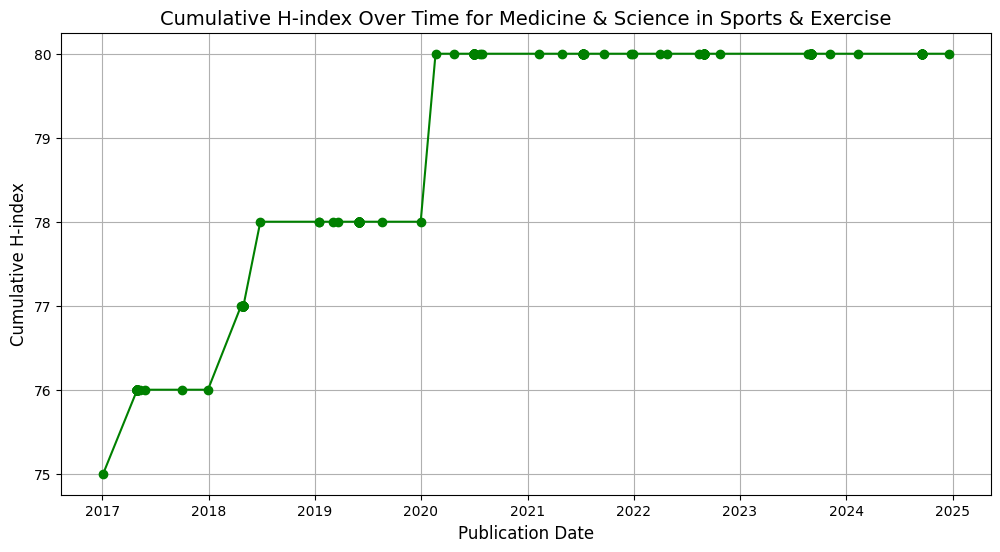

In [8]:
top_journal = final_df["journal_name"].value_counts().idxmax() #journal with most papers
journal_data = final_df[final_df["journal_name"] == top_journal]
plt.figure(figsize=(12, 6))
plt.plot(journal_data["publication_date"], journal_data["journal_h_index"], label=f"Cumulative H-index of {top_journal}", marker="o", color="green")
plt.title(f"Cumulative H-index Over Time for {top_journal}", fontsize=14)
plt.xlabel("Publication Date", fontsize=12)
plt.ylabel("Cumulative H-index", fontsize=12)
plt.grid(True)
plt.show()

/var/folders/66/n03tnlzs0fd6bhjtzdb8ztwm0000gn/T/ipykernel_4267/2003510990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data["cumulative_h_index"] = author_data["avg_author_h_index"].cummax()


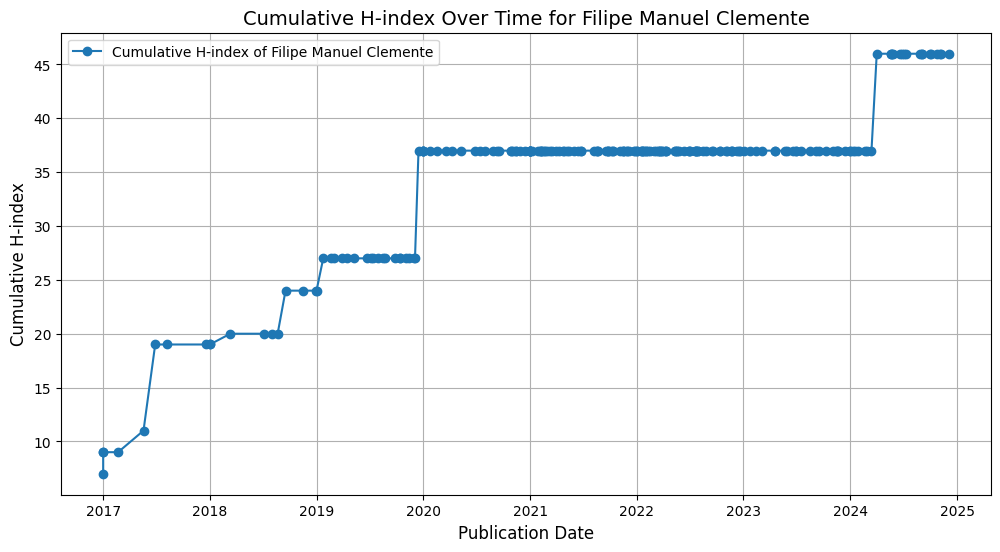

In [10]:
author_name = "Filipe Manuel Clemente"
author_data = final_df[final_df["authors"].apply(lambda x: author_name in x)]
author_data["cumulative_h_index"] = author_data["avg_author_h_index"].cummax()

plt.figure(figsize=(12, 6))
plt.plot(author_data["publication_date"], author_data["cumulative_h_index"], label=f"Cumulative H-index of {author_name}", marker="o")
plt.title(f"Cumulative H-index Over Time for {author_name}", fontsize=14)
plt.xlabel("Publication Date", fontsize=12)
plt.ylabel("Cumulative H-index", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
